In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from interpolation import interpolation, CensusData, dataprocessing, sequences
from interpolation import disambiguation_analysis as da

### Get Data

In [2]:
census_filled_file = "../../data/dwelling_filled_sum_1850_mn_v01.csv"

In [3]:
census = pd.read_csv("../../data/census_1850_indexUpdate.csv")
disambiguation = pd.read_csv("../../data/1850_disambiguated.csv")
city_directory = pd.read_csv("../../data/cd_1850_XYupdate.csv")

In [4]:
ward_col = "CENSUS_WARD_NUM"
dwelling_col = "dwelling_id"
block_col = "BLOCK_NUM"
cd_ward_col = "Ward_Num"
cd_block_col = "block_num"
dwelling_num_col = "CENSUS_DWELLING_NUM"

### Initial disambiguation analysis

In [5]:
census_disamb = da.add_disamb_census(disambiguation, census)

In [6]:
print("City directory match rate:", disambiguation["selected"].sum()/len(city_directory))
print("Census record match rate:", da.get_match_rate(census_disamb))

City directory match rate: 0.38776535611104135
Census record match rate: 0.023947404146384035


In [7]:
print("Census record match rate broken down by ward")
da.get_ward_match(census_disamb, ward_col = ward_col)

Census record match rate broken down by ward
Ward  1 :  0.03072
Ward  2 :  0.02329
Ward  3 :  0.01516
Ward  4 :  0.02417
Ward  5 :  0.03491
Ward  6 :  0.01737
Ward  7 :  0.03071
Ward  8 :  0.03522
Ward  9 :  0.03911
Ward  10 :  0.02385
Ward  11 :  0.01006
Ward  12 :  0.0
Ward  13 :  0.03558
Ward  14 :  0.02957
Ward  15 :  0.02291
Ward  16 :  0.0277
Ward  17 :  0.01691
Ward  18 :  0.01141
Ward  19 :  0.00016


In [8]:
#create unique dwelling id
census_disamb = census_disamb.groupby(ward_col, as_index = False).apply(lambda x: dataprocessing.create_unique_dwelling(x, dwelling_num_col))

### Disambiguation dwelling conflicts and resolution analysis

**Problem:** Disambiguation matched city directory and census records which represent individual people. Sometimes, people who lived in the same dwelling were assigned different addresses. How do we assign dwellings with address conflicts from disambiguation a single address?\
**Solution:** Use spatial weight created from disambiguation process and select address with the largest some of spatial weights\
**Reasoning:**
1. When disambiguating looking for similarity between individuals makes use of available information, and seems more likely to be accurate as a result. Any construction of dwelling similarity seems much weaker. Creating the final match with bipartite matching is an elegant approach that won't work on the dwelling level because different dwellings can be assigned the same address
2. Using the sum of spatial weights gives more weight to an address that is assigned multiple times within a dwelling

**Remaining Questions:**
1. When there's a tie in sum of spatial weight the process simply selects first option. This is consistent with the disambiguation approach to this solution. Can we create a more rigorous approach to resolving ties?

For more detail about exploration of this problem and solutions: [Dwelling Sequences.ipynb](https://github.com/CenterForSpatialResearch/hnyc-spatial-linkage/blob/spatial_linkage/tks/Interpolation/Dwelling%20Addresses.ipynb)

In [9]:
total_num_dwellings = census_disamb.groupby([ward_col, dwelling_col]).ngroups

In [10]:
conflicts_info = da.get_counts(census_disamb, ward_col = ward_col, dwelling_col = dwelling_col)

In [11]:
print("Proportion of dwelling records with single address match:", round(sum(conflicts_info["single_address"][0].values())/total_num_dwellings, 5))
print("Proportion of dwelling records with multiple address matches:",round(sum(conflicts_info["multiple_addresses"][0].values())/total_num_dwellings, 5))
print("Proportion of dwelling records without any match:", round(sum(conflicts_info["no_address"][0].values())/total_num_dwellings, 5))
print("Proportion of dwellings with address after resolving conflicts:", round((sum(conflicts_info["single_address"][0].values()) + sum(conflicts_info["multiple_addresses"][0].values()))/total_num_dwellings, 5))

Proportion of dwelling records with single address match: 0.19129
Proportion of dwelling records with multiple address matches: 0.04528
Proportion of dwelling records without any match: 0.76343
Proportion of dwellings with address after resolving conflicts: 0.23657


In [12]:
print("Proportion of census records with single address match:", round(conflicts_info["single_address"][1]/len(census_disamb), 5))
print("Proportion of census records with multiple address matches:",round(conflicts_info["multiple_addresses"][1]/len(census_disamb), 5))
print("Proportion of census records without any match:", round(conflicts_info["no_address"][1]/len(census_disamb), 5))
print("Proportion of census records with address after resolving conflicts:", round((conflicts_info["single_address"][1] + conflicts_info["multiple_addresses"][1])/len(census_disamb), 5))

Proportion of census records with single address match: 0.23208
Proportion of census records with multiple address matches: 0.09083
Proportion of census records without any match: 0.67709
Proportion of census records with address after resolving conflicts: 0.32291


In [13]:
ward_dwelling_conflict_info = pd.DataFrame([x[0] for x in conflicts_info.values()], index=[key for key in conflicts_info]).T
ward_dwelling_conflict_info.fillna(0, inplace = True)
ward_dwelling_conflict_info = ward_dwelling_conflict_info.transform(lambda x: x / x.sum(), axis = 1)
ward_dwelling_conflict_info["with_address"] = ward_dwelling_conflict_info["single_address"] + ward_dwelling_conflict_info["multiple_addresses"]

In [14]:
print("Ward break down of dwelling proportions")
display(ward_dwelling_conflict_info)

Ward break down of dwelling proportions


,no_address,single_address,multiple_addresses,with_address
1,0.657674,0.233488,0.108837,0.342326
2,0.827692,0.127692,0.044615,0.172308
3,0.826265,0.146375,0.027360,0.173735
4,0.692058,0.226904,0.081037,0.307942
5,0.708004,0.239625,0.052372,0.291996
6,0.759088,0.208125,0.032787,0.240912
7,0.706422,0.231352,0.062226,0.293578
8,0.667881,0.261471,0.070648,0.332119
9,0.674299,0.258729,0.066972,0.325701
10,0.783960,0.183960,0.032080,0.216040


In [15]:
#Resolve dwelling conflicts
census_filled = census_disamb.groupby([ward_col, dwelling_col]).apply(lambda x: da.dwelling_weight_fill(x, block_col = block_col))
#Add in values dropped because they don't have a dwelling number
census_filled = pd.concat([census_filled, census_disamb[census_disamb[dwelling_col].isnull()]], sort= True)
census_filled.reset_index(drop = True, inplace = True)
census_filled.to_csv(census_filled_file, index = False)

In [16]:
census_filled.head()

,BLOCK_NUM,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_NUM,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,CENSUS_GEOG,...,CENSUS_PLACE,CENSUS_RACE,CENSUS_REEL_HOUSEHOLD,CENSUS_SEQ_NUM,CENSUS_SERIALP,CENSUS_SEX,CENSUS_WARD_NUM,dwelling_id,spatial_weight,spatial_weight_sum
0,3794.0,37 South,-74.00825,40.703128,49,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,MANHATTAN,120,534,1,2044262,1,1,1,NaN,NaN
1,3794.0,37 South,-74.00825,40.703128,36,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,MANHATTAN,120,534,2,2044263,2,1,1,NaN,NaN
2,3794.0,37 South,-74.00825,40.703128,12,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,MANHATTAN,120,534,3,2044264,2,1,1,NaN,NaN
3,3794.0,37 South,-74.00825,40.703128,40,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,MANHATTAN,120,534,4,2044265,1,1,1,NaN,NaN
4,3794.0,37 South,-74.00825,40.703128,28,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,MANHATTAN,120,534,5,2044266,2,1,1,NaN,NaN


In [17]:
census_filled_dwellings = census_filled.groupby([ward_col, dwelling_col], as_index = False).first()

In [18]:
print("Census record match rate:", da.get_match_rate(census_filled))
print("Dwelling record match rate:", da.get_match_rate(census_filled_dwellings))

Census record match rate: 0.32290595969978475
Dwelling record match rate: 0.23656639004149377


### Block number analysis

In [19]:
blocks = [{}, {}, {}]
for ward in city_directory[cd_ward_col].dropna().unique():
    cd = city_directory[city_directory[cd_ward_col] == ward]
    cens = census_filled_dwellings[census_filled_dwellings[ward_col] == ward]
    
    blocks[0][ward] = cens[block_col].nunique()
    blocks[1][ward] = cd[cd_block_col].nunique()
    blocks[2][ward] = round(blocks[0][ward]/blocks[1][ward], 5)

In [20]:
blocks_info = pd.DataFrame(blocks, index=["census blocks", "cd blocks", "proportion of census blocks in cd"]).T.sort_index()
display(blocks_info)

,census blocks,cd blocks,proportion of census blocks in cd
1.0,72.0,82.0,0.87805
2.0,38.0,49.0,0.77551
3.0,38.0,43.0,0.88372
4.0,46.0,49.0,0.93878
5.0,75.0,76.0,0.98684
6.0,42.0,45.0,0.93333
7.0,72.0,72.0,1.00000
8.0,61.0,63.0,0.96825
9.0,107.0,112.0,0.95536
10.0,45.0,45.0,1.00000


### Engineered sequence analysis

**Problem:** Enumeration sequences are a useful way to think about how to branch out beyond addresses assigned through disambiguation. Intuitively an enumeration sequence is a sequence of dwellings an enumerator visited and recorded consecutively. However all we have is the order of records in the census without any indication of breaks. How do we engineer approximate sequences from census record order?\
**Solution:** Select maximum distance between consecutive known dwellings, and start a new sequence when distance exceeds the maximum. Select maximum distance through tuning process which minimizing the difference in sequence length, and then the number of sequences with lengths specified in list (here I chose to mimize sequences with a length of one).\
**Reasoning:**
1. Logically most of the time the next dwelling an enumerator went to wouldn't be far from the previous dwelling
2. Allows creation of reasonably sequences with only address information with disambiguation process
3. This approach seemed to improve model performance
4. When tuning, minimize difference in sequence length because extremely large variation in sequence length seems unlikely
5. When tuning, break ties in sequence length difference by minimizing sequence lengths in list because we may want to minimize sequences with only one dwelling, or sequences with very large numbers of dwellings

**Remaining Questions:**
1. How else can sequences be created? Could another approach be added in and contribute to relation between dwellings and space?
2. Should we limit sequence length numerically? For example an enumerator visiting over 1000 dwellings at a time could be unlikely.

For more discussions of this problem and analysis of the approach: 
- [Interpolation Pilot.ipynb - Enumeration Patterns Section](https://github.com/CenterForSpatialResearch/hnyc-spatial-linkage/blob/spatial_linkage/tks/Interpolation/Interpolation%20Pilots.ipynb)
- [Examining Sequence Patterns.ipynb](https://github.com/CenterForSpatialResearch/hnyc-spatial-linkage/blob/spatial_linkage/tks/Interpolation/Examining%20Sequence%20Patterns.ipynb)

In [21]:
dwellings_dropped = census_filled_dwellings.dropna(subset = [block_col])
dwellings_dropped = dwellings_dropped.groupby(ward_col, as_index = False).apply(sequences.col_for_seq)

In [22]:
#Select maximum possible distance between consecutive known addresses
#Based on two options, number of 
options = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
minimize_lengths = [1]
sequence_tuning = sequences.tune_sequence_dist(dwellings_dropped, options, minimize_lengths)
print("Selected maximum distance between consecutive dwellings:", sequence_tuning["dist"])
dwellings_sequence = sequence_tuning["df"]

d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d

In [25]:
#Add back in dropped rows
all_dwellings_graph = dataprocessing.dwellings_to_all(census_filled_dwellings, dwellings_sequence, list(set(list(dwellings_sequence.columns)).difference(list(census_filled_dwellings.columns))) + [ward_col, dwelling_col], [ward_col, dwelling_col])
sequence_graph_df = all_dwellings_graph.dropna(subset = ["CD_X"]).copy()
sequence_graph_df["sequence_id"] = sequence_graph_df["sequence_id"].ffill()

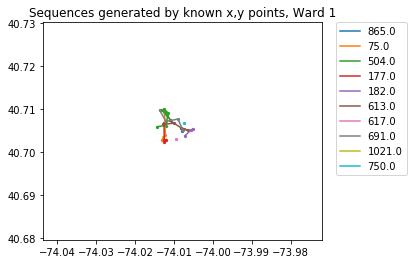

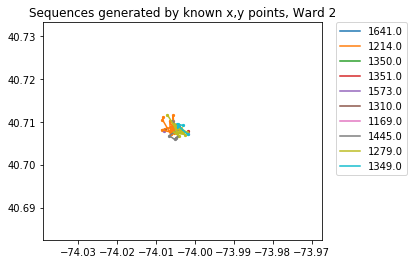

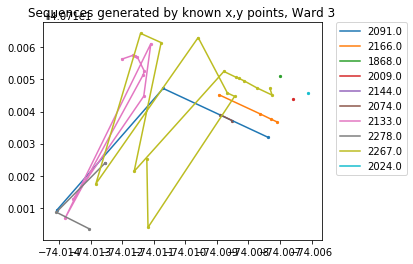

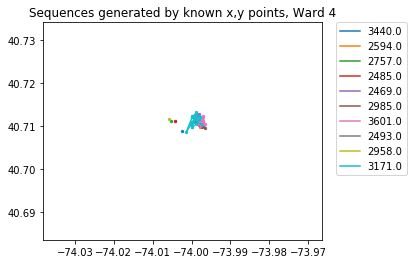

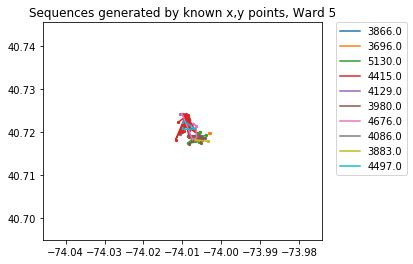

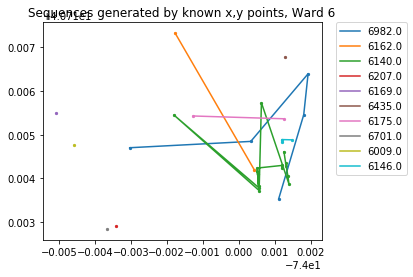

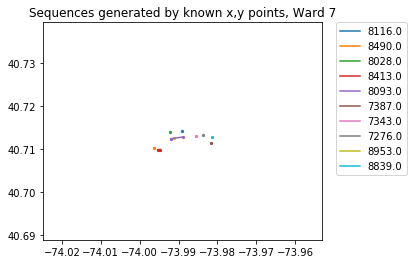

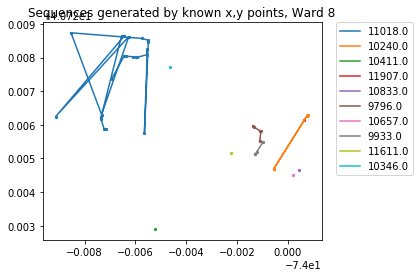

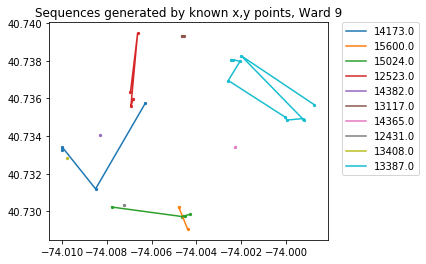

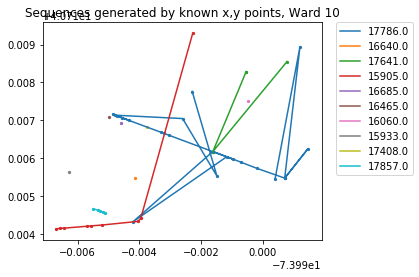

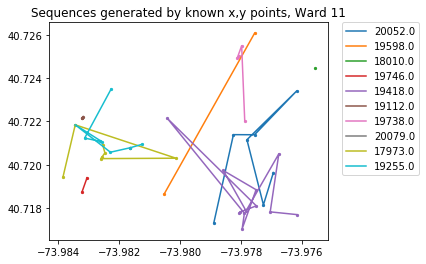

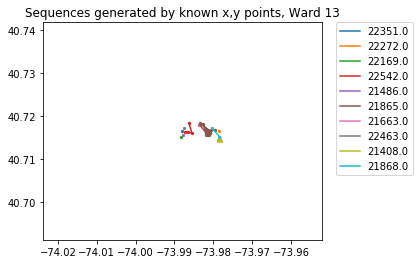

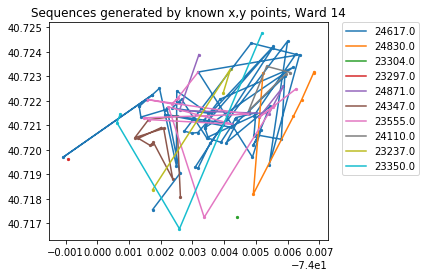

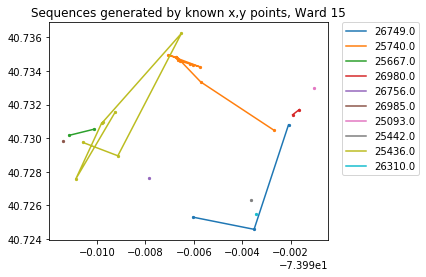

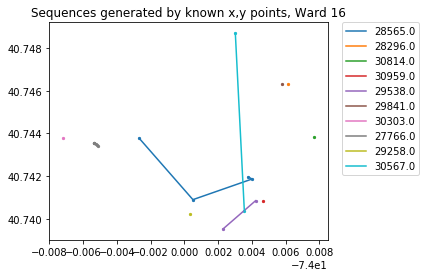

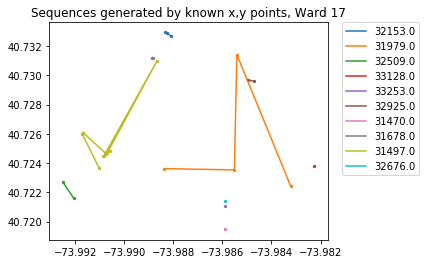

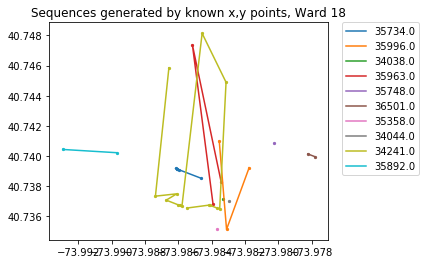

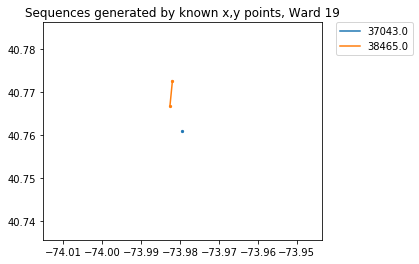

In [26]:
for ward in sequence_graph_df[ward_col].unique():
    fig,ax = plt.subplots(1,1, figsize = (5,4))
    dwellings_w = sequence_graph_df[sequence_graph_df[ward_col] == ward]
    
    if dwellings_w["sequence_id"].nunique() <= 10:
        sequences = dwellings_w["sequence_id"].unique()
    else:
        sequences = np.random.choice(dwellings_w["sequence_id"].unique(), 10, replace = False)
    
    colors = [plt.rcParams['axes.prop_cycle'].by_key()['color'][x] for x in range(len(sequences))]
    
    for sequence, color in zip(sequences, colors):
        dwelling_seq = dwellings_w[dwellings_w["sequence_id"] == sequence]
        ax.plot(dwelling_seq["CD_X"], dwelling_seq["CD_Y"], label = sequence, color = color)
        ax.scatter(dwelling_seq["CD_X"], dwelling_seq["CD_Y"], s = 5, color = color)
    ax.set_title("Sequences generated by known x,y points, Ward "+str(ward))
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

### Interpolation Between Known Addresses

**Problem:** Intuitively, if, during the disambiguation process consecutive known dwellings have the same block number or street name, it seems possible that the dwellings in between those known addresses would share that block number/street name. How accurate is making that assumption and simply filling in those unknown block numbers/street names? And how many dwellings can we gather more information for that way? How many dwellings should we limit this process to. For example, if there are 100 dwellings in between known address the validity of simply filling in the block number feels weaker than if there were only 2 dwellings in between.\
**Method:** Get known consecutive dwellings with shared block numbers/street name and dwellings with unknown addresses in between. Experiment with different limits of number of dwellings in between

In [119]:
## 1. Get dwellings that are followed by unknown dwellings whose block num can be interpolated
## dwellings_sequence => known dwellings with sequence_id
dwelling_sequence_sames = interpolation.same_next(dwellings_sequence, column = block_col)

"""
2. Merge dwelling_sequence_sames back to all known dwelling df so that `BLOCK_NUM_next` and 
`num_between_real` are included in df of all known dwellings.
"""
dwellings_sequence_with_next_info = dwellings_sequence.merge(dwelling_sequence_sames[[ward_col, dwelling_col,
                                                                                      'BLOCK_NUM_next', 
                                                                                      'num_between_real',
                                                                                      'header']], 
                                                             on=[ward_col, dwelling_col], how='left')

"""
3. Merge `dwellings_sequence_with_next_info` back to df of all dwellings. Ffill sequences between 
2 known dwellings of the same sequences [not really. need to be fixed !!]
"""
all_dwellings = dataprocessing.all_dwellings_sequenced(census_filled_dwellings, dwellings_sequence_with_next_info, 
                                                       ward_col = ward_col, dwelling_col = dwelling_col)

"""
4. Get consecutive dwellings that are in between 2 known dwellngs of the same sequence and block_col value.
Used for plotting.
"""
interpolate_dwellings = interpolation.get_consecutive_dwellings(all_dwellings, column = block_col)

'\n4. Get consecutive dwellings that are in between 2 known dwellngs of the same sequence and block_col value.\nUsed for plotting.\n'

In [126]:
all_dwellings[['sequence_id']]

,sequence_id
0,38.0
1,38.0
2,38.0
3,38.0
4,38.0
...,...
38555,38465.0
38556,38465.0
38557,38465.0
38558,38465.0


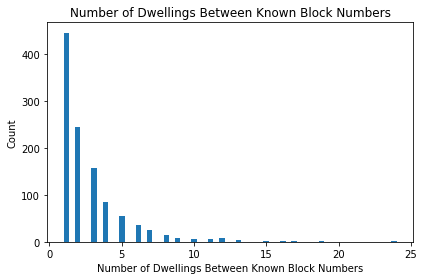

In [123]:
plt.hist(interpolate_dwellings["num_between_real"], bins = "auto")
plt.xlabel("Number of Dwellings Between Known Block Numbers")
plt.ylabel("Count")
plt.title("Number of Dwellings Between Known Block Numbers")
plt.tight_layout()
plt.show()

In [124]:
num_between = [5,10,25,40]
for num in num_between:
    to_interpolate = interpolation.limit_dwellings_between(interpolate_dwellings,num)
    total_interpolate = to_interpolate["CD_ADDRESS"].isnull().sum()
    print("Maximum of {} dwellings between".format(str(num)))
    display(to_interpolate.loc[:,[ward_col, dwelling_col, block_col, "CD_ADDRESS", "CD_X", "CD_Y", "sequence_id"]].head(10))
    print("Number of dwellings that would be assigned a block:", total_interpolate)
    print("Proportion increase dwellings assigned a block:", round(total_interpolate/total_num_dwellings, 5), "\n")

Maximum of 5 dwellings between


,CENSUS_WARD_NUM,dwelling_id,BLOCK_NUM,CD_ADDRESS,CD_X,CD_Y,sequence_id
56,1,57,649.0,38 Pearl,-74.012254,40.703218,59.0
57,1,58,NaN,NaN,NaN,NaN,59.0
58,1,59,649.0,1 State,-74.013034,40.702485,59.0
129,1,130,718.0,74 Wall,-74.008098,40.705684,136.0
130,1,131,NaN,NaN,NaN,NaN,136.0
131,1,132,NaN,NaN,NaN,NaN,136.0
132,1,133,NaN,NaN,NaN,NaN,136.0
133,1,134,718.0,52 Wall,-74.009058,40.706209,136.0
251,1,252,649.0,11 State,-74.014071,40.702725,264.0
252,1,253,NaN,NaN,NaN,NaN,264.0


Number of dwellings that would be assigned a block: 2015
Proportion increase dwellings assigned a block: 0.05226 

Maximum of 10 dwellings between


,CENSUS_WARD_NUM,dwelling_id,BLOCK_NUM,CD_ADDRESS,CD_X,CD_Y,sequence_id
56,1,57,649.0,38 Pearl,-74.012254,40.703218,59.0
57,1,58,NaN,NaN,NaN,NaN,59.0
58,1,59,649.0,1 State,-74.013034,40.702485,59.0
129,1,130,718.0,74 Wall,-74.008098,40.705684,136.0
130,1,131,NaN,NaN,NaN,NaN,136.0
131,1,132,NaN,NaN,NaN,NaN,136.0
132,1,133,NaN,NaN,NaN,NaN,136.0
133,1,134,718.0,52 Wall,-74.009058,40.706209,136.0
251,1,252,649.0,11 State,-74.014071,40.702725,264.0
252,1,253,NaN,NaN,NaN,NaN,264.0


Number of dwellings that would be assigned a block: 2653
Proportion increase dwellings assigned a block: 0.0688 

Maximum of 25 dwellings between


,CENSUS_WARD_NUM,dwelling_id,BLOCK_NUM,CD_ADDRESS,CD_X,CD_Y,sequence_id
56,1,57,649.0,38 Pearl,-74.012254,40.703218,59.0
57,1,58,NaN,NaN,NaN,NaN,59.0
58,1,59,649.0,1 State,-74.013034,40.702485,59.0
129,1,130,718.0,74 Wall,-74.008098,40.705684,136.0
130,1,131,NaN,NaN,NaN,NaN,136.0
131,1,132,NaN,NaN,NaN,NaN,136.0
132,1,133,NaN,NaN,NaN,NaN,136.0
133,1,134,718.0,52 Wall,-74.009058,40.706209,136.0
251,1,252,649.0,11 State,-74.014071,40.702725,264.0
252,1,253,NaN,NaN,NaN,NaN,264.0


Number of dwellings that would be assigned a block: 2971
Proportion increase dwellings assigned a block: 0.07705 

Maximum of 40 dwellings between


,CENSUS_WARD_NUM,dwelling_id,BLOCK_NUM,CD_ADDRESS,CD_X,CD_Y,sequence_id
56,1,57,649.0,38 Pearl,-74.012254,40.703218,59.0
57,1,58,NaN,NaN,NaN,NaN,59.0
58,1,59,649.0,1 State,-74.013034,40.702485,59.0
129,1,130,718.0,74 Wall,-74.008098,40.705684,136.0
130,1,131,NaN,NaN,NaN,NaN,136.0
131,1,132,NaN,NaN,NaN,NaN,136.0
132,1,133,NaN,NaN,NaN,NaN,136.0
133,1,134,718.0,52 Wall,-74.009058,40.706209,136.0
251,1,252,649.0,11 State,-74.014071,40.702725,264.0
252,1,253,NaN,NaN,NaN,NaN,264.0


Number of dwellings that would be assigned a block: 2971
Proportion increase dwellings assigned a block: 0.07705 

